In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
data.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Data preparation

In [3]:
data.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [4]:
data.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical = ['lead_source', 'industry', 'employment_status', 'location']

data[numerical] = data[numerical].fillna(0)
data[categorical] = data[categorical].fillna('NA')

## 1. Mode for `industry`

In [6]:
data['industry'].value_counts()

industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64

## 2. Correlation matrix for numerical features

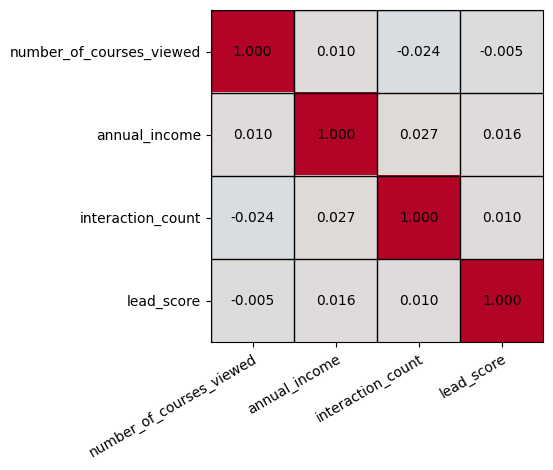

In [7]:
corr_matrix = data[numerical].corr()

plt.imshow(corr_matrix, vmin=-1, vmax=1, cmap="coolwarm")
for x in range(len(corr_matrix)):
    for y in range(len(corr_matrix)):
        plt.text(x, y, f"{corr_matrix.values[x][y]:.3f}", ha="center", va="center")

plt.xticks(ticks=range(0, 4), labels=numerical, rotation=30, rotation_mode="anchor", ha='right')
plt.yticks(ticks=range(0, 4), labels=numerical)

plt.xticks(np.arange(0, 4)-.5, minor=True)
plt.yticks(np.arange(0, 4)-.5, minor=True)
plt.grid(which="minor", color="black", linewidth=1)
plt.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
plt.show()

## Split the data

In [8]:
full_train, test = train_test_split(data, test_size=.2, random_state=42)
train, val = train_test_split(full_train, test_size=.25, random_state=42)

df_train = train.drop('converted', axis=1)
y_train = train['converted']

df_val = val.drop('converted', axis=1)
y_val = val['converted']

df_test = test.drop('converted', axis=1)
y_test = test['converted']

## 3. Mutual info

In [9]:
print("Mutual info between 'converted' and: ")

for col in df_train[categorical]:
    print(f"'{col}': {mutual_info_score(df_train[col], y_train):.2f}")

Mutual info between 'converted' and: 
'lead_source': 0.04
'industry': 0.01
'employment_status': 0.01
'location': 0.00


## 4. Training a logistic regression

In [10]:
vec = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient="records")
X_train = vec.fit_transform(train_dict)
X_val = vec.transform(df_val.to_dict(orient="records"))

logreg = LogisticRegression(random_state=42, solver='liblinear', C=1, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict_proba(X_val)[:, 1]
y_pred = [1 if p > 0.5 else 0 for p in y_pred]

score = accuracy_score(y_val, y_pred)
round(score, 2)

0.7

## 5. Feature filtering

In [11]:
scores = {}

for col in df_train.columns:
    train_dict = df_train.drop(col, axis=1).to_dict(orient="records")
    X_train = vec.fit_transform(train_dict)
    X_val = vec.transform(df_val.drop(col, axis=1).to_dict(orient="records"))

    logreg = LogisticRegression(random_state=42, solver='liblinear', C=1, max_iter=1000)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict_proba(X_val)[:, 1]
    y_pred = [1 if p > 0.5 else 0 for p in y_pred]

    scores[col] = abs(score - accuracy_score(y_val, y_pred))

scores

{'lead_source': 0.0034129692832765013,
 'industry': 0.0,
 'number_of_courses_viewed': 0.14334470989761094,
 'annual_income': 0.15358361774744034,
 'employment_status': 0.0034129692832763903,
 'location': 0.010238907849829393,
 'interaction_count': 0.14334470989761094,
 'lead_score': 0.0068259385665528916}

## 6. Regularized logistic regression


In [12]:
C = [0.01, 0.1, 1, 10, 100]
scores = {}

for c in C:
    train_dict = df_train.drop(col, axis=1).to_dict(orient="records")
    X_train = vec.fit_transform(train_dict)
    X_val = vec.transform(df_val.drop(col, axis=1).to_dict(orient="records"))

    logreg = LogisticRegression(random_state=42, solver='liblinear', C=c, max_iter=1000)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict_proba(X_val)[:, 1]
    y_pred = [1 if p > 0.5 else 0 for p in y_pred]

    scores[c] = accuracy_score(y_val, y_pred)

scores

{0.01: 0.6962457337883959,
 0.1: 0.6996587030716723,
 1: 0.7064846416382252,
 10: 0.7064846416382252,
 100: 0.7064846416382252}